<a href="https://colab.research.google.com/github/deepalim100/Airplane-Detection-for-Satellites/blob/master/GeoTiff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install rasterio 

     |████████████████████████████████| 15.2MB 153kB/s 


In [6]:
data = rasterio.open('/content/Clip_347_2012 comp1.tif')

data.meta

{'count': 3,
 'crs': CRS.from_epsg(32643),
 'driver': 'GTiff',
 'dtype': 'float32',
 'height': 480,
 'nodata': -999.0,
 'transform': Affine(30.0, 0.0, 369105.0,
       0.0, -30.0, 2060115.0),
 'width': 668}

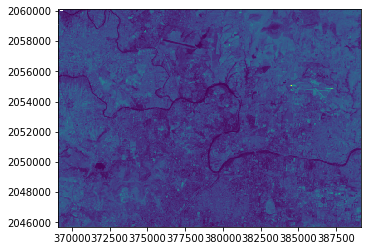

In [7]:
from rasterio import plot

plot.show(data)

In [13]:
img = data.read(1)
import numpy as np
#converting to integar
nv =(255 * img/ np.max(img)).astype(np.uint8);
nv

array([[248, 248, 248, ..., 248, 248, 248],
       [248, 248, 248, ...,  85,  73,  68],
       [248, 248, 248, ...,  84,  81,  65],
       ...,
       [ 54,  59,  66, ...,  68,  69,  78],
       [ 54,  62,  69, ...,  62,  53,  53],
       [248, 248, 248, ..., 248, 248, 248]], dtype=uint8)

In [0]:
#Method-1 - Using geo referncing and getgeotransform
from osgeo import osr, gdal

# get the existing coordinate system
ds = gdal.Open('/content/Clip_347_2012 comp1.tif')
old_cs= osr.SpatialReference()
old_cs.ImportFromWkt(ds.GetProjectionRef())

# create the new coordinate system
wgs84_wkt = """
GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.257223563,
            AUTHORITY["EPSG","7030"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0,
        AUTHORITY["EPSG","8901"]],
    UNIT["degree",0.01745329251994328,
        AUTHORITY["EPSG","9122"]],
    AUTHORITY["EPSG","4326"]]"""
new_cs = osr.SpatialReference()
new_cs .ImportFromWkt(wgs84_wkt)

# create a transform object to convert between coordinate systems
transform = osr.CoordinateTransformation(old_cs,new_cs) 

#get the point to transform, pixel (0,0) in this case
width = ds.RasterXSize
height = ds.RasterYSize
gt = ds.GetGeoTransform()
minx = gt[0]
miny = gt[3] + width*gt[4] + height*gt[5] 

#get the coordinates in lat long
latlong = transform.TransformPoint(minx,miny) 

In [37]:
latlong

(73.76009076971602, 18.497835899453086, 0.0)

In [38]:
gt

(369105.0, 30.0, 0.0, 2060115.0, 0.0, -30.0)

In [39]:
!pip install gpsimage
!pip install api

  Created wheel for gpsimage: filename=gpsimage-0.0.2-cp36-none-any.whl size=13536 sha256=bb871c603f7ac308b8d2f75dd35ff86217ce439745c554962aca97c9c970d685
  Stored in directory: /root/.cache/pip/wheels/ad/14/3d/52af1ea1fe7a22d25f1d50cdc8ea3c2a9237aa125da5a0eda9
Successfully built gpsimage
     |████████████████████████████████| 163kB 2.8MB/s 
  Created wheel for api: filename=api-0.0.7-cp36-none-any.whl size=2326 sha256=6769b739eb7a1f6a78e947d73557aea57e8f483207db3d907f74ff1e66ed91f6
  Stored in directory: /root/.cache/pip/wheels/8e/b3/13/6fb6612d6dd2d4bc2dfa783e9be7554e7c2f276912d3cb850e
Successfully built api


We can get the lat and long of Georefernce Image by using its api or url form too.

In [0]:
from osgeo import gdal
ds = gdal.Open('/content/Clip_347_2012 comp1.tif')
width = ds.RasterXSize
height = ds.RasterYSize
gt = ds.GetGeoTransform()
px = int((width - gt[0]) / gt[1]) #x pixel
py = int((height - gt[3]) / gt[5]) 


In [41]:
!pip install pyproj

In [42]:
#Method-2 - Transformation Method


import numpy as np
from affine import Affine
from pyproj import Proj, transform

fname = '/content/Clip_347_2012 comp1.tif'

# Read raster
with rasterio.open(fname) as r:
    T0 = r.transform  
    p1 = Proj(r.crs)
    A = r.read()  # pixel values

# All rows and columns
cols, rows = np.meshgrid(np.arange(A.shape[2]), np.arange(A.shape[1]))

# Get affine transform for pixel centres
T1 = T0 * Affine.translation(0.5, 0.5)
# Function to convert pixel row/column index (from 0) to easting/northing at centre
rc2en = lambda r, c: (c, r) * T1

# All eastings and northings
eastings, northings = np.vectorize(rc2en, otypes=[np.float, np.float])(rows, cols)

# Project all longitudes, latitudes
p2 = Proj(proj='latlong',datum='WGS84')
longs, lats = transform(p1, p2, eastings, northings)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: Right multiplication will be prohibited in version 3.0


In [43]:
print(longs[1][1], lats[0][1])

73.75957982149131 18.627821268883253
